In [1]:

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras.layers import Input, concatenate, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Dropout, UpSampling2D, ZeroPadding2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from skimage.transform import resize
import os
import csv
import PIL
import numpy as np
import random
import cv2
import imutils
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2

In [4]:
HEIGHT = 240
WIDTH = 320
INIT_LR = 0.0001
EPOCHS = 15
TRAIN_PATH = "/kaggle/input/kitti-csv-train-gt/kitti_train_mapping.csv"
TEST_PATH = "/kaggle/input/kitti-csv-train-gt/kitti_test_mapping.csv"

In [5]:
def downsampling_block(input_tensor, n_filters):
  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(input_tensor)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  return x

def upsampling_block(input_tensor, n_filters, name, concat_with):
  x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)
  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convA")(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = concatenate([x, concat_with], axis=3)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  return x

In [6]:
def build(height, width, depth):
  # input
  i = Input(shape=(height, width, depth))

  iresnet = InceptionResNetV2(include_top = False, weights = "imagenet", input_tensor = i)
  # iresnet.summary()

  conv1 = iresnet.get_layer("input_layer").output
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = iresnet.get_layer("activation").output
  conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)  
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = iresnet.get_layer("activation_3").output
  conv3 = ZeroPadding2D((1,1))(conv3)  
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = iresnet.get_layer("activation_74").output
  conv4 = ZeroPadding2D(((2,1),(2,1)))(conv4)  
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  

  # bottleneck
  conv5 = iresnet.get_layer("activation_161").output
  conv5 = ZeroPadding2D((1,1))(conv5) 
  conv5 = LeakyReLU(alpha=0.2)(conv5)
  conv5 = iresnet.get_layer("activation_161").output
  conv5 = ZeroPadding2D((1,1))(conv5)
  conv5 = LeakyReLU(alpha=0.2)(conv5)

  print(conv5.shape,conv4.shape)

  # decoder
  conv6 = upsampling_block(conv5, 256, "up1", concat_with=conv4)
  conv7 = upsampling_block(conv6, 128, "up2", concat_with=conv3)
  conv8 = upsampling_block(conv7, 64, "up3", concat_with=conv2)
  conv9 = upsampling_block(conv8, 32, "up4", concat_with=conv1)

  # output
  o = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='conv10')(conv9)

  model = Model(inputs=i, outputs=o)
  return model

In [7]:
model = build(HEIGHT, WIDTH, 3)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(None, 15, 20, 288) (None, 30, 40, 256)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [8]:
# model.summary()

In [9]:
# !git clone https://gitlab.com/siddinc/new_depth.git ./data

In [10]:
# loading the dataset

def read_csv(csv_file_path):
  with open(csv_file_path, 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    return [(row[0], row[1]) for row in csv_reader if len(row) > 0]

def train_val_split(train_paths, val_size):
  random.shuffle(train_paths)
  len_train_paths = len(train_paths)
  i = int(len_train_paths*(1.0 - val_size))
  train = train_paths[0:i]
  val = train_paths[i:len(train_paths)]
  return train, val

def load_train_paths(train_path):
  train_paths = read_csv(train_path)
  labels = {img_path: dm_path for img_path, dm_path in train_paths}
  x_paths = [img_path for img_path, dm in train_paths]
  x_train_paths, x_val_paths = train_val_split(x_paths, 0.3)

  partition = {
    'train': x_train_paths,
    'validation': x_val_paths
  }
  return partition, labels

In [12]:
def normalize_img(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def preprocess_image(img_path, horizontal_flip=False):
    image = cv2.imread(img_path)
    image = imutils.resize(image, height=240)  # Resize height to 240
    image = cv2.resize(image, (320, 240))  # Ensure width is 320
    image = image.astype("float")
    image = normalize_img(image)

    if horizontal_flip:
        image = cv2.flip(image, 1)
    return image

def preprocess_depth_map(depth_map_path, horizontal_flip=False):
    depth_map = cv2.imread(depth_map_path)
    depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
    depth_map = imutils.resize(depth_map, height=240)  # Resize height to 240
    depth_map = cv2.resize(depth_map, (320, 240))  # Ensure width is 320
    depth_map = depth_map.astype("float")
    depth_map = normalize_img(depth_map)

    if horizontal_flip:
        depth_map = cv2.flip(depth_map, 1)

    depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
    return depth_map


In [13]:
# data generator

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
  def __init__(self, list_IDs, labels, batch_size=16, dim=(128,128), n_channels=3, shuffle=True, pred=False):
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.shuffle = shuffle
    self.pred = pred
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    if self.pred:
      X = self.__data_generation(list_IDs_temp)
      return X
    X, y = self.__data_generation(list_IDs_temp)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, self.dim[0], self.dim[1],self.n_channels))

    if not self.pred:
      y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1))

      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
        y[i,] = preprocess_depth_map(self.labels[ID], res)
      return X, y
    else:
      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
      return X

In [14]:
partition, labels = load_train_paths(TRAIN_PATH)

In [15]:
print(len(partition['train']), len(partition['validation']))

5096 2185


In [18]:
training_generator = DataGenerator(list_IDs=partition['train'], labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=partition['validation'], labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

In [19]:
def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

opt = Adam(learning_rate=INIT_LR, amsgrad=True)
callbacks = [LearningRateScheduler(poly_decay)]

# custom loss
def depth_loss(y_true, y_pred):
  w1, w2, w3 = 1.0, 1.0, 0.3

  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

def depth_acc(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Ensure both are float32
    y_pred = K.cast(y_pred, 'float32')
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [20]:
model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])

In [22]:
# model.fit(training_generator, validation_data=validation_generator, epochs=15, callbacks=callbacks)

In [23]:
# model.save("iresnetv2_new_kitti_15.keras")

In [24]:
r = model.load_weights("/kaggle/input/kitti_model_irv2/keras/default/1/iresnetv2_new_kitti_15.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1256 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
img_dm_pairs = read_csv('/kaggle/input/kitti-csv-train-gt/kitti_test_mapping.csv')
labels = {i: j for i,j in img_dm_pairs}
test_paths = [i for i,j in img_dm_pairs]
print(len(test_paths))
partition = {'test': test_paths}

200


In [28]:
x_test = np.empty((len(test_paths), HEIGHT, WIDTH, 3))
y_test = np.empty((len(test_paths), HEIGHT, WIDTH, 1))

for i, ID in enumerate(partition['test'][:]):
  x_test[i, ] = preprocess_image(ID, horizontal_flip=False)
  y_test[i, ] = preprocess_depth_map(labels[ID], horizontal_flip=False)

In [29]:
print(model.evaluate(x_test, y_test))

7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - depth_acc: 0.9832 - loss: 0.0512
[0.051283594220876694, 0.9832645654678345]


In [30]:
y_pred = model.predict(x_test)
y_true = y_test

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step 


In [31]:
import time
import numpy as np
import matplotlib.pyplot as plt

start_time = time.time()
test_samples = model.predict(x_test)
end_time = time.time()
total_time = end_time - start_time
num_samples = len(x_test)
avg_time_per_image = total_time / num_samples
print(f"Average test time per image: {avg_time_per_image:.6f} seconds")


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 431ms/step
Average test time per image: 0.017065 seconds


In [33]:

def preprocess_image2(img_path, horizontal_flip=False):
    image = cv2.imread(img_path)
    image = imutils.resize(image, height=240)  # Resize height to 240
    image = cv2.resize(image, (640, 240))  # Ensure width is 320
    image = image.astype("float")
    image = normalize_img(image)

    if horizontal_flip:
        image = cv2.flip(image, 1)
    return image

def preprocess_depth_map2(depth_map_path, horizontal_flip=False):
    depth_map = cv2.imread(depth_map_path)
    depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
    depth_map = imutils.resize(depth_map, height=240)  # Resize height to 240
    depth_map = cv2.resize(depth_map, (640, 240))  # Ensure width is 320
    depth_map = depth_map.astype("float")
    depth_map = normalize_img(depth_map)

    if horizontal_flip:
        depth_map = cv2.flip(depth_map, 1)

    depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
    return depth_map


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step


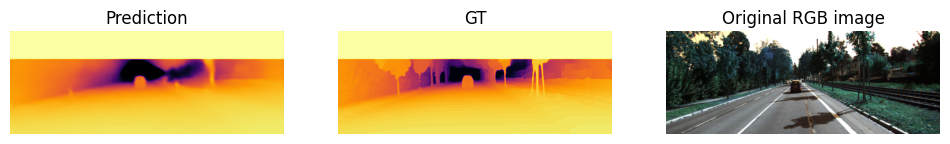

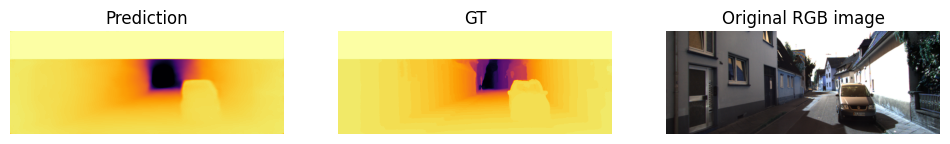

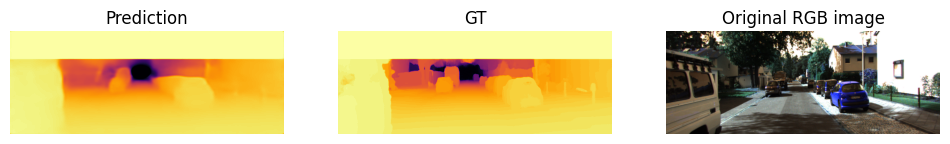

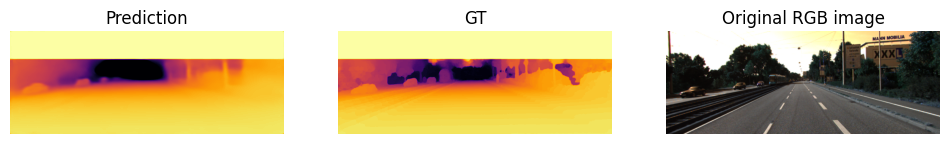

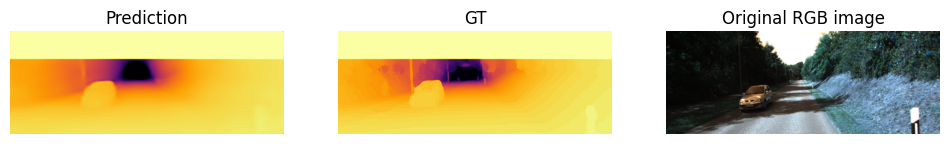

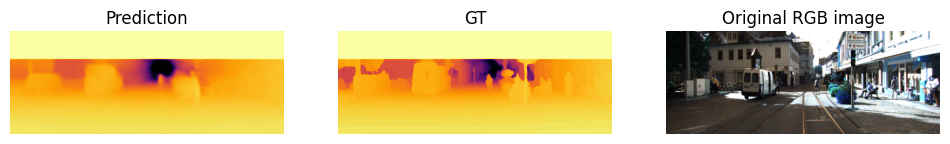

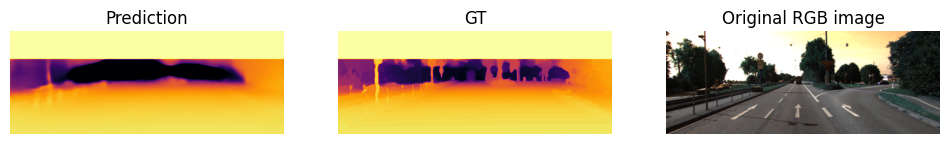

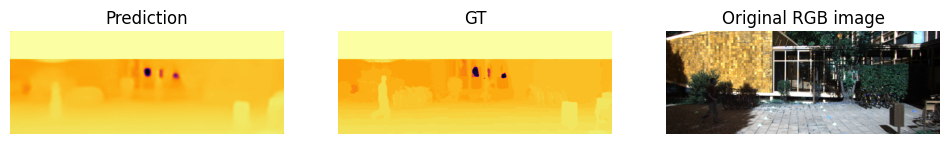

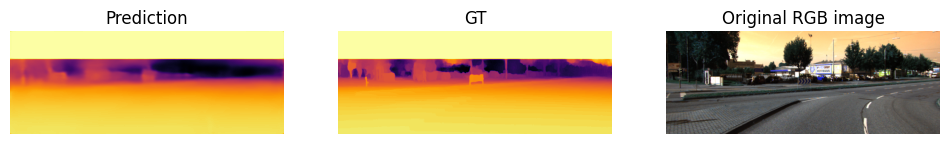

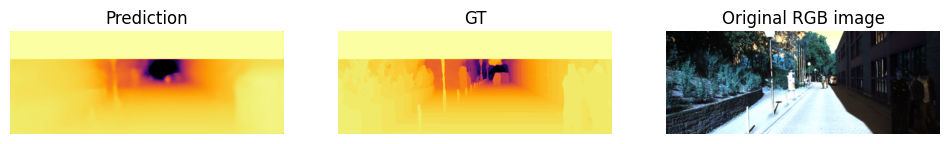

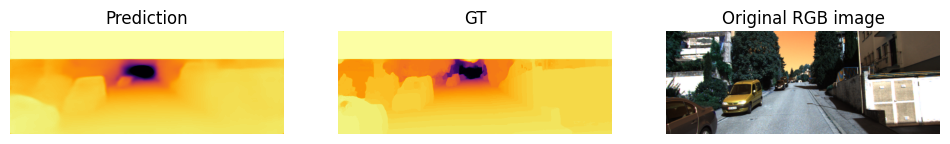

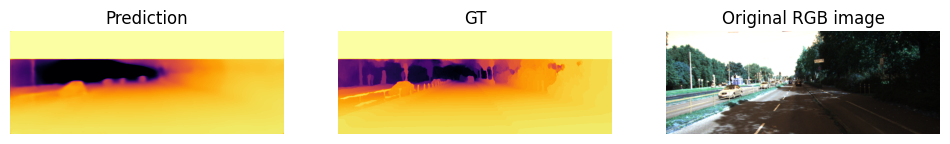

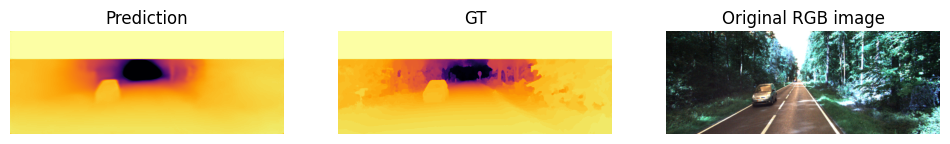

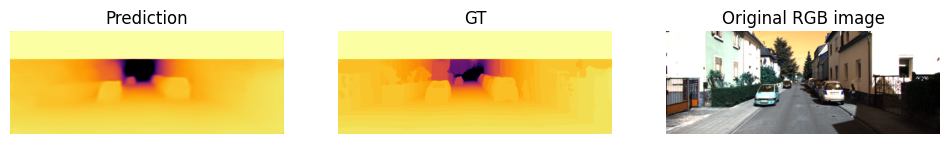

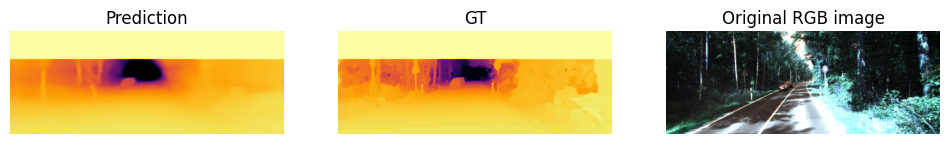

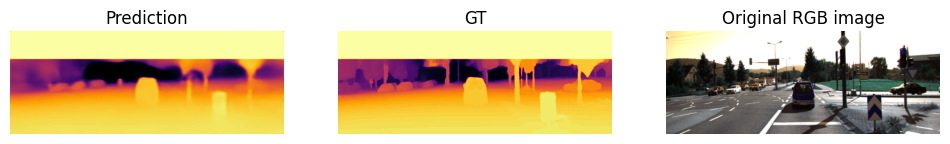

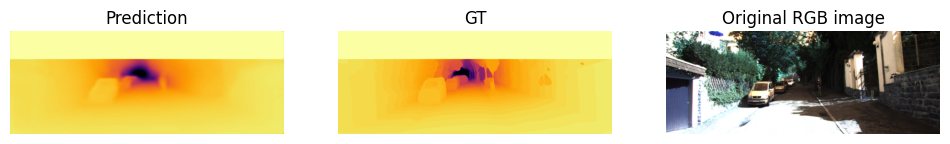

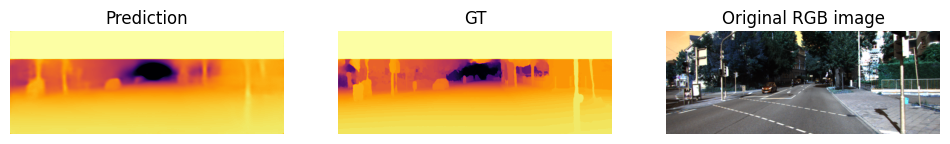

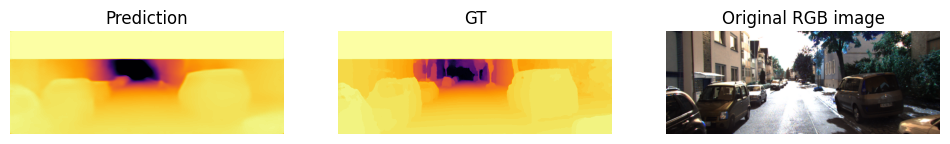

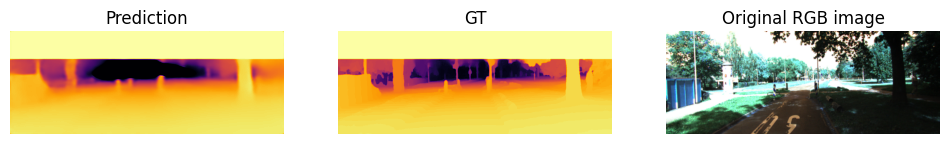

In [34]:
import matplotlib.pyplot as plt
import numpy as np

preds = model.predict(x_test)

for i in range(len(test_paths)-180):
  path = partition['test'][i]
  label_path = labels[path]
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)
  # pred = pred.squeeze().cpu().numpy()  
  # pred = (pred * 255 / np.max(pred)).astype("uint8")  
  plt.figure(figsize=(12, 4))
    
    
  plt.subplot(1,3,1)
  plt.axis("off")
  plt.title("Prediction")
  pred = cv2.resize(pred, (640, 240))  
  plt.imshow(pred, cmap=plt.get_cmap('inferno_r'))

  plt.subplot(1,3,2)
  plt.axis("off")
  plt.title("GT")
  img = preprocess_depth_map2(label_path, horizontal_flip=False)
  # img = (img * 255 / np.max(img)).astype("uint8")   
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap('inferno_r'))

  plt.subplot(1,3,3)
  plt.axis("off")
  plt.title("Original RGB image")
  img1 = preprocess_image2(path, horizontal_flip=False)
  plt.imshow(img1)

  plt.show()

# **Apply Noise, Blur, Occlusion and Got Output**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


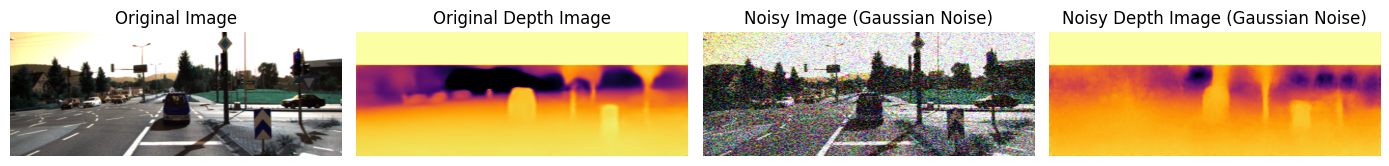

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests
import cv2
import matplotlib.pyplot as plt

# Load the image
image = x_test[15]

# Add stronger Gaussian noise
mean = 0
std_dev = 0.3  # Increase the standard deviation to make the noise stronger
gaussian_noise = np.random.normal(mean, std_dev, image.shape)  # Generate Gaussian noise

# Apply noise to the image
noisy_image = image + gaussian_noise


depth2 = preds[15]
# visualize the prediction
noisy_image = cv2.resize(noisy_image, (640, 240))
noisy_image = np.expand_dims(noisy_image, axis=0)  # Add batch dimension
depth = model.predict(noisy_image)



# print(image_np.shape, depth2.shape, noisy_image.shape, depth.shape)
# Plot the original and noisy images
plt.figure(figsize=(14, 7))

# Original image
plt.subplot(1, 4, 1)
# image_np = np.squeeze(image_np, axis=0)
image = cv2.resize(image, (640, 240))
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
# depth2 = np.squeeze(depth2, axis=0)
depth2 = cv2.resize(depth2, (640, 240))
plt.imshow(depth2, cmap='inferno_r')
plt.title("Original Depth Image")
plt.axis("off")

# Noisy image
plt.subplot(1, 4, 3)
noisy_image = np.squeeze(noisy_image, axis=0)
plt.imshow(noisy_image)
plt.title("Noisy Image (Gaussian Noise)")
plt.axis("off")

plt.subplot(1, 4, 4)
depth = np.squeeze(depth, axis=0)
plt.imshow(depth, cmap='inferno_r')
plt.title("Noisy Depth Image (Gaussian Noise)")
plt.axis("off")


plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


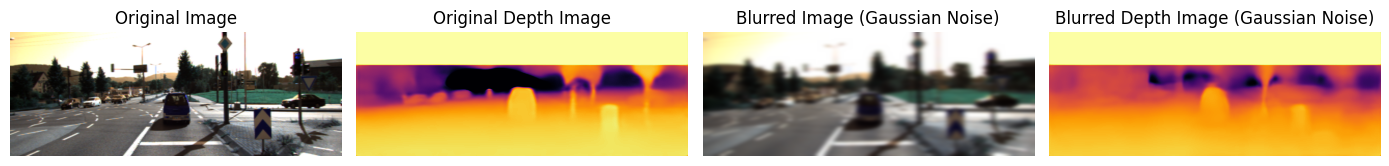

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests
import cv2
import matplotlib.pyplot as plt

# Load the image
image = x_test[15]

# Add stronger Gaussian noise
kernel_size = (15, 15)  # Size of the Gaussian kernel
blurred_image = cv2.GaussianBlur(image, kernel_size, sigmaX=0)


depth2 = preds[15]
# visualize the prediction
blurred_image = cv2.resize(blurred_image, (640, 240))
blurred_image = np.expand_dims(blurred_image, axis=0)  # Add batch dimension
depth = model.predict(blurred_image)



# print(image_np.shape, depth2.shape, noisy_image.shape, depth.shape)
# Plot the original and noisy images
plt.figure(figsize=(14, 7))

# Original image
plt.subplot(1, 4, 1)
# image_np = np.squeeze(image_np, axis=0)
image = cv2.resize(image, (640, 240))
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
# depth2 = np.squeeze(depth2, axis=0)
depth2 = cv2.resize(depth2, (640, 240))
plt.imshow(depth2, cmap='inferno_r')
plt.title("Original Depth Image")
plt.axis("off")

# Noisy image
plt.subplot(1, 4, 3)
blurred_image = np.squeeze(blurred_image, axis=0)
plt.imshow(blurred_image)
plt.title("Blurred Image (Gaussian Noise)")
plt.axis("off")

plt.subplot(1, 4, 4)
depth = np.squeeze(depth, axis=0)
plt.imshow(depth, cmap='inferno_r')
plt.title("Blurred Depth Image (Gaussian Noise)")
plt.axis("off")


plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


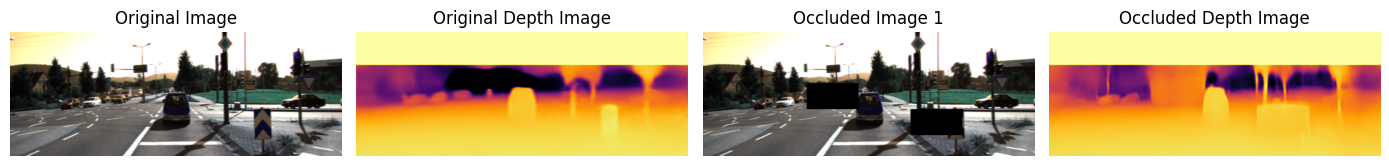

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
import torch
import cv2

# Load the image
image = x_test[15]

# Apply first occlusion (mask part of the image)
occlusion_size_1 = (50, 50)  # Size of the first occluded area (width, height)
occlusion_position_1 = (100, 100)  # Position to start the first occlusion (x, y)

# Apply second occlusion (mask part of the image)
occlusion_size_2 = (50, 50)  # Size of the second occluded area (width, height)
occlusion_position_2 = (200, 150)  # Position to start the second occlusion (x, y)

# Create a copy of the image and apply both occlusions
occluded_image = np.copy(image)
occluded_image[occlusion_position_1[1]:occlusion_position_1[1]+occlusion_size_1[1],
               occlusion_position_1[0]:occlusion_position_1[0]+occlusion_size_1[0]] = 0  # Set the first occluded part to black

occluded_image[occlusion_position_2[1]:occlusion_position_2[1]+occlusion_size_2[1],
               occlusion_position_2[0]:occlusion_position_2[0]+occlusion_size_2[0]] = 0  # Set the second occluded part to black

depth2 = preds[15]

# Visualize the prediction
occluded_image_resized = cv2.resize(occluded_image, (640, 240))
occluded_image_resized = np.expand_dims(occluded_image_resized, axis=0)  # Add batch dimension
depth = model.predict(occluded_image_resized)

# Plot the original and occluded images
plt.figure(figsize=(14, 7))

# Original image
plt.subplot(1, 4, 1)
image = cv2.resize(image, (640, 240))
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
depth2 = cv2.resize(depth2, (640, 240))
plt.imshow(depth2, cmap='inferno_r')
plt.title("Original Depth Image")
plt.axis("off")

# First occluded image
plt.subplot(1, 4, 3)
occluded_image_resized_1 = np.squeeze(occluded_image_resized, axis=0)
plt.imshow(occluded_image_resized_1)
plt.title("Occluded Image 1")
plt.axis("off")

# Occluded depth image
plt.subplot(1, 4, 4)
depth = np.squeeze(depth, axis=0)
plt.imshow(depth, cmap='inferno_r')
plt.title("Occluded Depth Image")
plt.axis("off")

# Second occluded image (to demonstrate the effect of the second occlusion)
occluded_image[occlusion_position_1[1]:occlusion_position_1[1]+occlusion_size_1[1],
               occlusion_position_1[0]:occlusion_position_1[0]+occlusion_size_1[0]] = 0  # Reset first occlusion
occluded_image[occlusion_position_2[1]:occlusion_position_2[1]+occlusion_size_2[1],
               occlusion_position_2[0]:occlusion_position_2[0]+occlusion_size_2[0]] = 0  # Set second occlusion again

# plt.subplot(1, 5, 5)
# occluded_image_resized_2 = np.expand_dims(cv2.resize(occluded_image, (320, 240)), axis=0)
# occluded_image_resized_2 = np.squeeze(occluded_image_resized_2, axis=0)
# plt.imshow(occluded_image_resized_2)
# plt.title("Occluded Image 2")
# plt.axis("off")

plt.tight_layout()
plt.show()


# **Performance Evaluation**

In [ ]:
import numpy as np
from sklearn.metrics import r2_score
from tensorflow.keras.layers import AveragePooling2D

r2_scores = []

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=6):
    # Support multiple RGBs, one RGB image, even grayscale   
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    images = tf.image.resize(images, [240, 320])
    predictions = model.predict(images, batch_size=batch_size)
    return predictions

def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []    
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append( resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True ) )
    return np.stack(scaled)

def evaluate(model, rgb, depth, batch_size=6):
    def compute_errors(gt, pred):
        pred = cv2.resize(pred, (gt.shape[1], gt.shape[0]))  # Resize pred to match gt
        gt = np.squeeze(gt)  # Shape: (H, W)
        # Avoid division by zero and log of zero
        epsilon = 1e-4
        gt[gt <= 0] = epsilon
        pred[pred <= 0] = epsilon
        pred = cv2.resize(pred, (gt.shape[1], gt.shape[0]))
        
        gt_pool = np.expand_dims(np.expand_dims(gt, axis=0), axis=-1)  # Shape: (1, H, W, 1)
        pred_pool = np.expand_dims(np.expand_dims(pred, axis=0), axis=-1)  # Shape: (1, H, W, 1)
        gt_pool = AveragePooling2D(pool_size=(7, 7), strides=(2, 2))(gt_pool)
        pred_pool = AveragePooling2D(pool_size=(7, 7), strides=(2, 2))(pred_pool)
        gt_pool = np.squeeze(gt_pool)  # Shape: (H_new, W_new)
        pred_pool = np.squeeze(pred_pool)  # Shape: (H_new, W_new)
        # Flatten the depth maps
        ground_truth_flat = gt_pool.flatten()
        predicted_flat = pred_pool.flatten()
    
        # Compute R^2 score for the current image and store it
        r2 = r2_score(ground_truth_flat, predicted_flat)
        r2_scores.append(r2)

        thresh = np.maximum((gt / pred), (pred / gt))
        
        a1 = (thresh < 1.25   ).mean()
        a2 = (thresh < 1.25 ** 2).mean()
        a3 = (thresh < 1.25 ** 3).mean()

        abs_rel = np.mean((np.abs(gt>pred - pred) / gt>pred))
        
        rmse = (gt - pred) ** 2 
        rmse = np.sqrt(rmse.mean())

        log_10 = (np.abs(np.log10(gt)-np.log10(pred))).mean()

        return a1, a2, a3, abs_rel, rmse, log_10

    depth_scores = np.zeros((6, len(rgb)))

    bs = batch_size

    for i in range(len(rgb)//bs):   
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        pred_y = scale_up(2, predict(model, x/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0
        # Test time augmentation: mirror image estimate
        pred_y_flip = scale_up(2, predict(model, x[...,::-1,:]/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0

        
        # Compute errors per image in batch
        for j in range(len(true_y)):
#             errors = compute_errors(true_y[j], (0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j])))
            errors = compute_errors((true_y[j]), (0.75 * pred_y[j]))

            
            for k in range(len(errors)):
                depth_scores[k][(i*bs)+j] = errors[k]

    e = depth_scores.mean(axis=1)

    print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
    print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))


# rgb, depth, crop = load_test_data() 
rgb = x_test
depth = y_test
evaluate(model, rgb, depth)